# Process images (pilot)

Take images from raw download folder and process into appropriate data:
 - Filter images which were not downloaded
 - Compress images to smaller size
 - Filter images which do not contain the desired subject material

## Config

In [24]:

import matplotlib.pyplot as plt
from pathlib import Path
import logging
from IPython.display import Image, display
import PIL
from glob import glob
from collections import defaultdict
import cv2
import pytesseract
from typing import Dict, Callable, Tuple
import numpy as np

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.propagate = False
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

In [2]:
# Notebook Parameters
dataset_base_path = Path('..', 'datasets', 'pilot_raw')

## Filter raw examples into usable examples

### Filter 1: Remove un-identifiable images
Some images could not be downloaded, we will filter by if trying to read the file produces an unidentifiable image error

In [3]:
dataset_folders = {
    'positive': Path(dataset_base_path, 'positive'),
    'negative': Path(dataset_base_path, 'negative')
}

In [4]:
def not_downloaded_filter(im_path: str) -> bool:
    """Return True if image file can be read, false if not identifiable"""
    try:
        plt.imread(im_path)
        return True
    except PIL.UnidentifiedImageError:
        return False

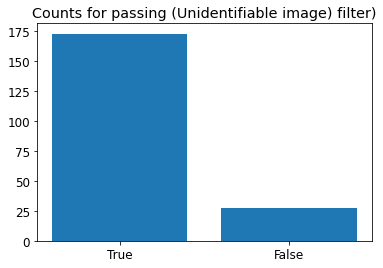

In [5]:
filter_count = defaultdict(int)
for filepath in (glob(str(dataset_folders['positive']) + '/*') +
                 glob(str(dataset_folders['negative']) + '/*')):
    filter_count[str(not_downloaded_filter(filepath))] += 1
    
plt.bar(*zip(*filter_count.items()))
plt.title("Counts for passing (Unidentifiable image) filter)")
plt.show()
 

### Filter 2: Remove images with text
Lots of images do not really display the plan but rather are a generic figure or overlay, a common theme in these images is that they have text in the image. Try to filter these out using 

In [6]:
bad_example = Path(dataset_base_path, 'positive', 'poison_ivy_plant_4.jpg')
normal_example = Path(dataset_base_path, 'positive', 'poison_ivy_plant_1.jpg')
text_example = Path(dataset_base_path, 'positive', 'poison_ivy_plant_18.jpg')

print("Normal example: ")
print(type(cv2.imread(str(normal_example))))

Normal example: 
<class 'numpy.ndarray'>


Normal example: 


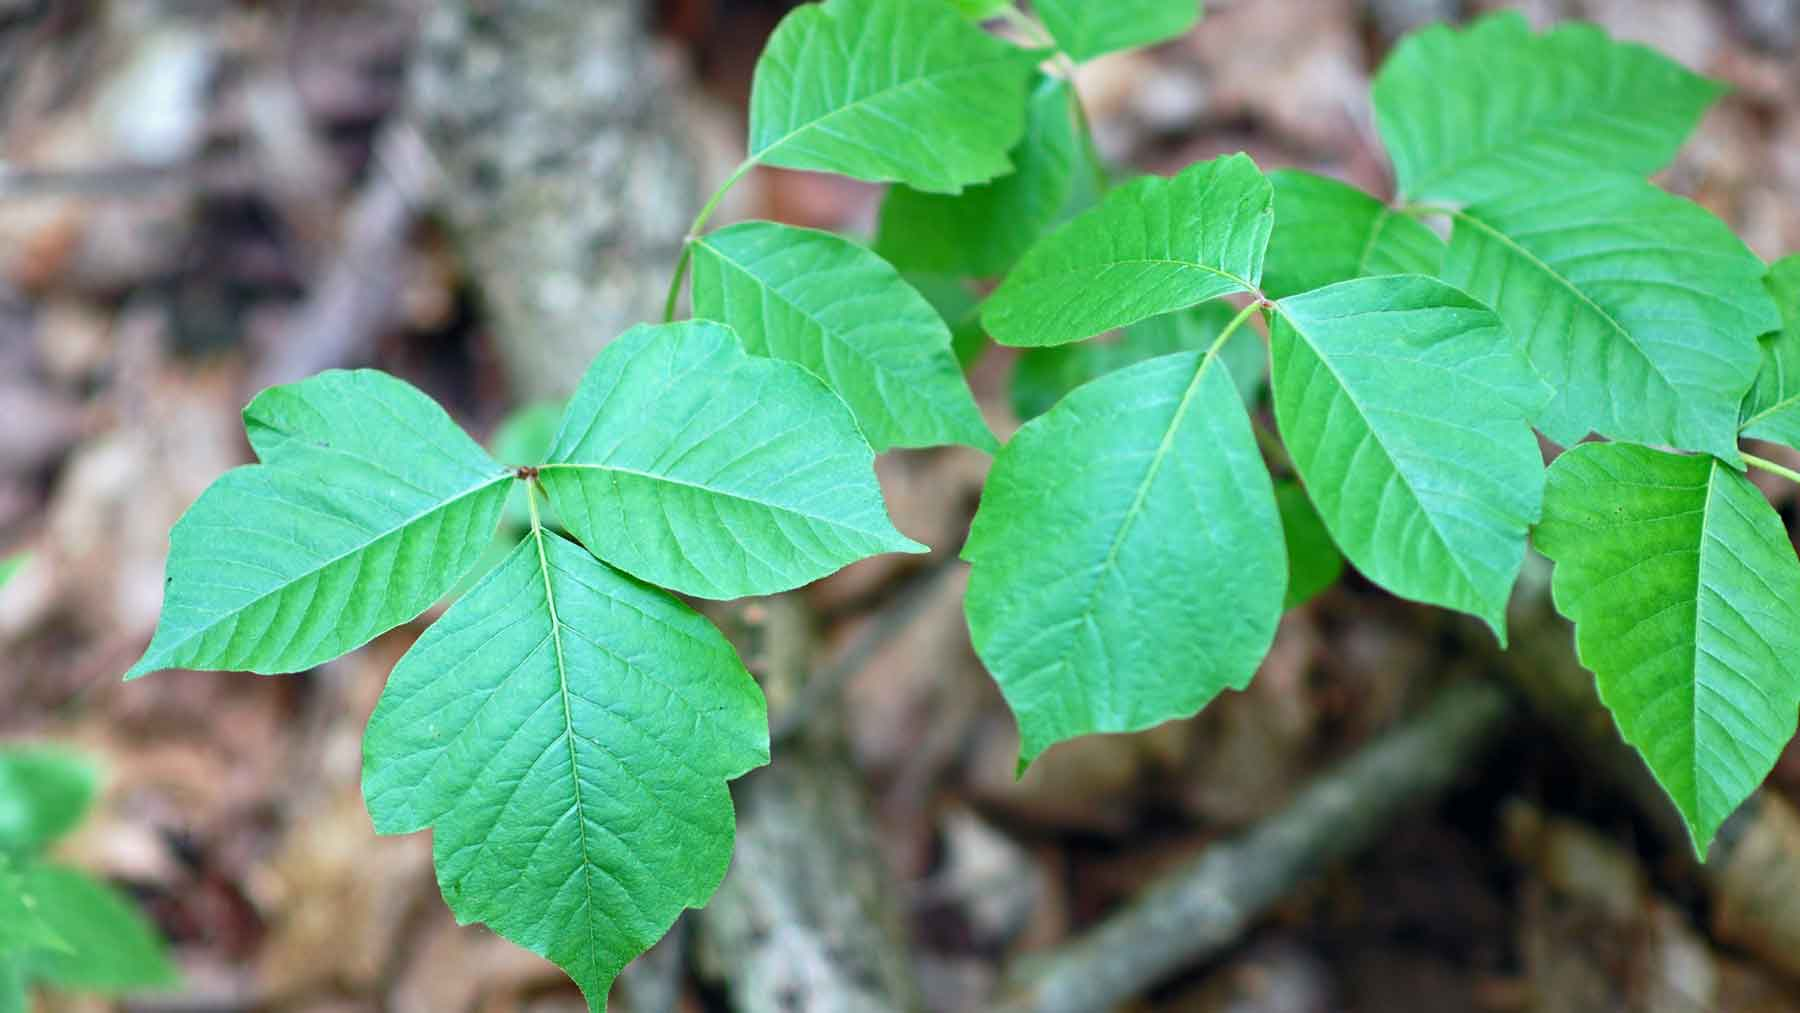

Image text:  

Text example (Bad): 


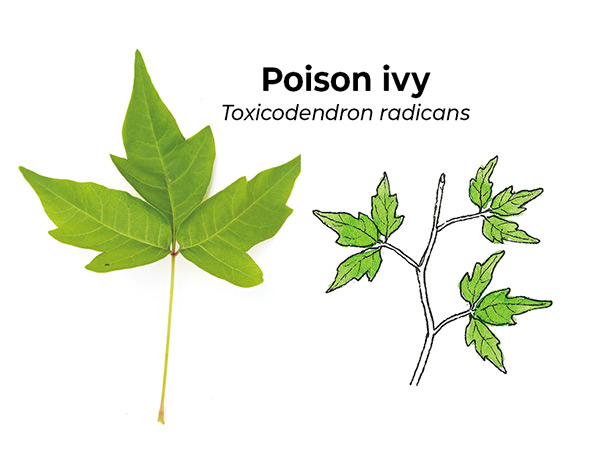

Image text: Poison ivy

Toxicodendron radicans



In [12]:
print("Normal example: ")
display(Image(filename=str(normal_example), height=200))
normal_im = cv2.imread(str(normal_example))
normal_text = pytesseract.image_to_string(normal_im)
print(f"Image text: {normal_text}")

print("Text example (Bad): ")
display(Image(filename=str(text_example), height=200))
text_im = cv2.imread(str(text_example))
text_text = pytesseract.image_to_string(text_im)
print(f"Image text: {text_text}")

None


In [16]:
def contains_text_filer(img: np.ndarray) -> bool:
    return(pytesseract.image_to_string(img).strip() == '')

NameError: name 'np' is not defined

In [26]:
def apply_filters_to_path(im_path:str,
                          filters: Dict[str, Callable[[np.ndarray], bool]],
                          passed_str:str = "Passed",
                          not_read_str:str = "Image_not_read") -> Tuple[bool, str]:
    """
    Apply a series of filters of to an image path
    By default checks if image can be read
    Then checks based on dictionary of {filter name: filter function}
    Returns a tuple of (Passed? (boolean), which filter failed or passed_str)
    """
    img = cv2.imread
    if img is None:
        return (False, not_read_str) # Image could not be read
    
    for filter_name, filter_func in filters.items():
        if not filter_func(img):
            return (False, filter_name)
        
    return(True, passed_str) # No filters failed